In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df = pd.read_excel("Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [6]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
# furniture.index
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


# Average sales per month

In [8]:
y = furniture['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

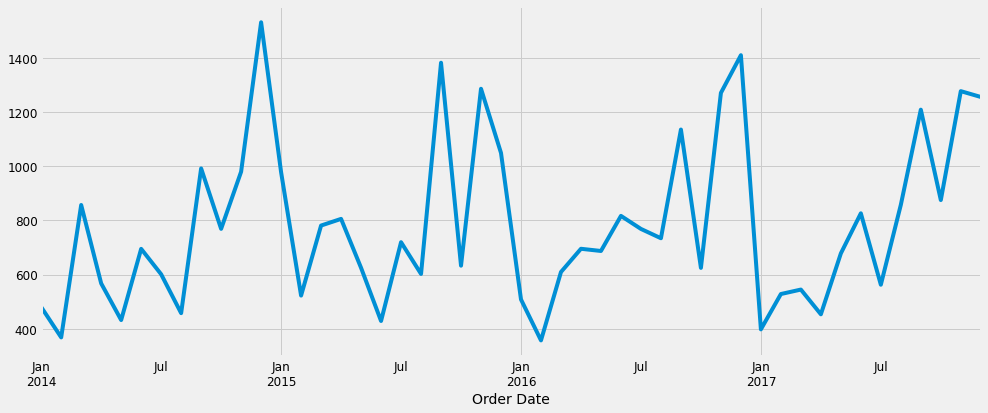

In [9]:
y.plot(figsize=(15, 6))
plt.show()

### Visualizing data using time-series decomposition that allows us to decompose our time series into three distinct components: 
* trend
* seasonality
* noise

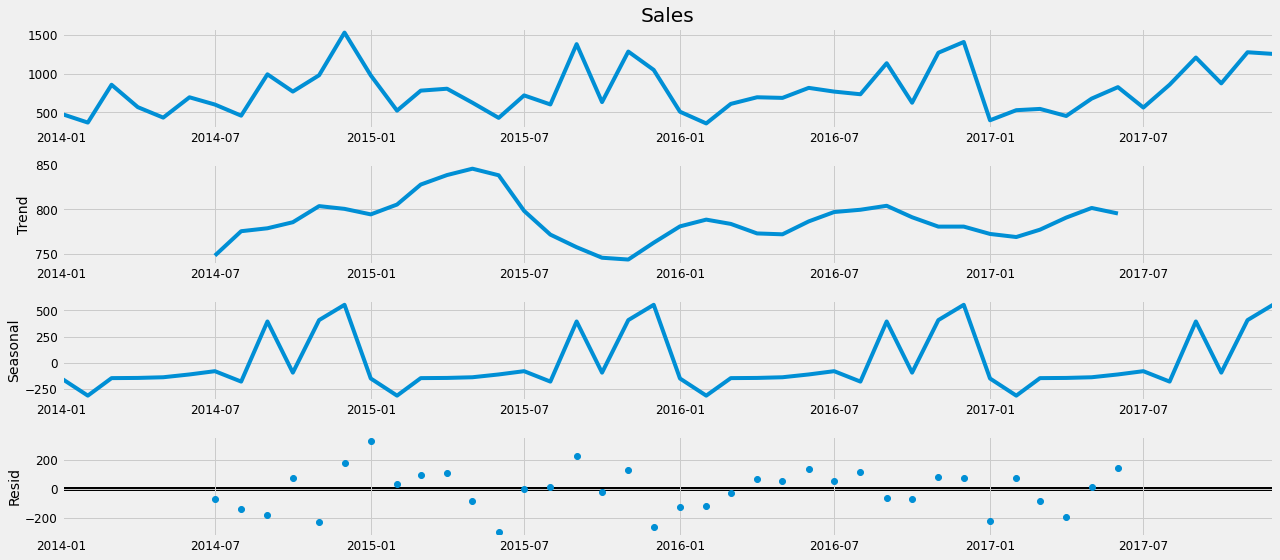

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Forcasting using ARIMA (AutoRegressive Integrated Moving Average)

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# Grid search to get best value for p, d, q

In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1377.6737760934338
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997936975
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1351.9870527777302
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280302665
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758109
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2729.072618268503
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809163


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732944
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.596169194252


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2596.5441486651466
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576429577
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1419.5229124116067
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.9671228167956
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1427.5538425319955
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200151471
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817193
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3273.8903190805663
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482836
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062316810697
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774425985
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2815.6702397164836
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417252
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612436
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1299.6923251853673
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609645
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935201
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1235.4410171865957
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084546
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438553
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442186298
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2669.5950391144597


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958150464
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659585
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876872
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2538.03381188337
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002197207
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188154284
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1361.1057477374725
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281135
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619095
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.340365878503
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:4513145211.160381
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345417
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.32649925127873
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835535
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:8999.750822500157
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687609949
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939403
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.525035466085
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2669.7116740937036
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439535705
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661017772306


ARIMA(1, 1, 1)x(1, 1, 0, 12) yields lowest AIC: 297.79

# Fitting ARIMA Model

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
# print(results.summary().tables[1])

In [14]:
# # Model diagnostics to check for any unusual behaviour
# results.plot_diagnostics(figsize=(16, 8))
# plt.show()

# Model validation

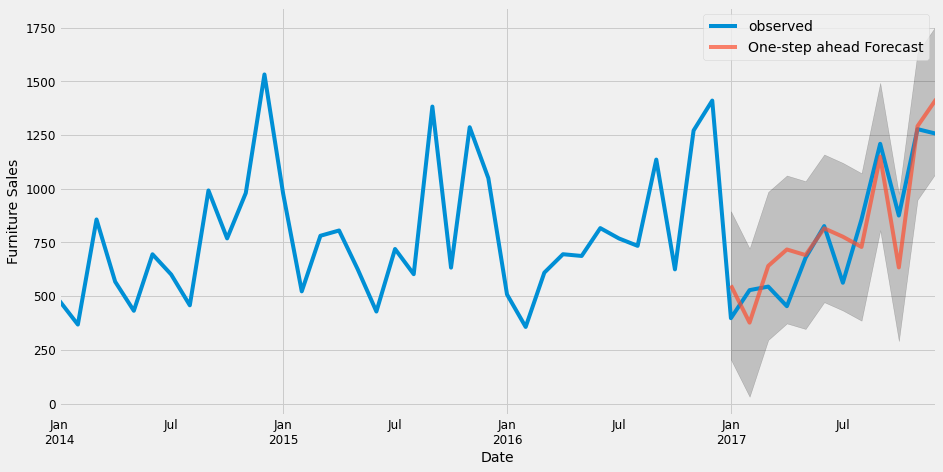

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 22993.57
The Root Mean Squared Error of our forecasts is 151.64


# Forecasts

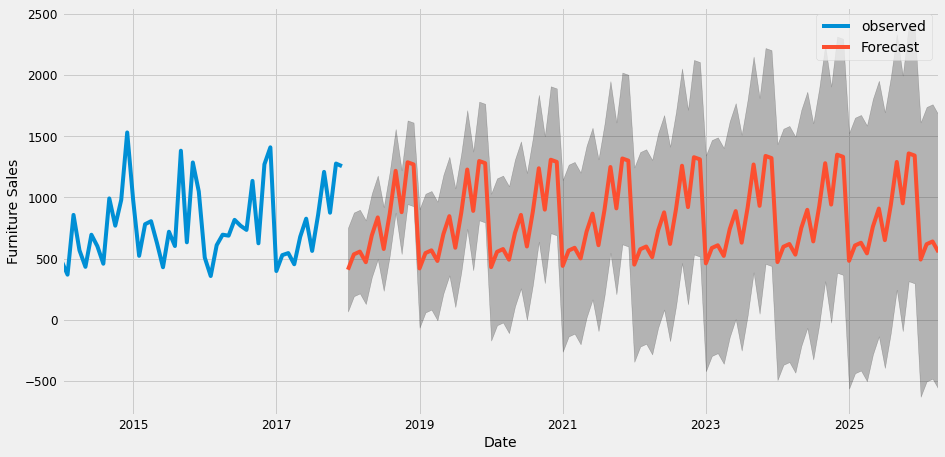

In [17]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()